# Introduction to Human Activity Recognition

Here we will explore some common ways of preprocessing human activity recognition data.

Using the example data we will learn:
* how to merge multiple files into one large DataFrame
* how to split data into sliding windows
* how to quickly extract features from a window
* how to set the number of classes considered for classification
* how to build a simple Random Forest Classifier and train it on HAR data
* how to build a simple CNN and train it on HAR data 

Bear in mind that the sample data offered is not cleaned or high quality. You should not use it in your own experiments but it is useful for this tutorial.

You will need the following packages: 
* tsfresh
* scikit-learn
* tensorflow

#### Basic imports

In [1]:
import pandas as pd
import numpy as np
import tsfresh
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import tensorflow as tf

import os

import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import LSTM

from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics as kmetrics
import tensorflow.keras.backend as K

## Loading multiple files into one large DataFrame

At this stage you should only be working with clean data, saved in the format required for Coursework 1. An example of such data can be found in the Data/Clean/ folder.

In [2]:
base_df = pd.DataFrame()

clean_data_folder = "./Data/Clean"

for filename in os.listdir(clean_data_folder):
    full_path = f"{clean_data_folder}/{filename}"
    print(full_path)
    
    # load data into a DataFrame
    new_df = pd.read_csv(full_path)
    
    # merge into the base DataFrame
    base_df = pd.concat([base_df, new_df])

./Data/Clean/Respeck_s1711661_Standing_23-09-2021_19-58-56.csv
./Data/Clean/Respeck_s1718069_Sitting bent forward_29-09-2021_12-25-17.csv
./Data/Clean/Respeck_s1718069_Standing_29-09-2021_12-26-43.csv
./Data/Clean/Respeck_s1732873_Walking at normal speed_04-10-2021_15-30-06.csv
./Data/Clean/Respeck_s1724279_Standing_30-09-2021_12-34-44.csv
./Data/Clean/Respeck_s1727780_Sitting bent forward_29-09-2021_21-39-24.csv
./Data/Clean/Respeck_s1718069_Walking at normal speed_29-09-2021_12-27-51.csv
./Data/Clean/Respeck_s1724067_Walking at normal speed_06-10-2021_19-54-01.csv
./Data/Clean/Respeck_s1721256_Standing_01-10-2021_19-00-30.csv
./Data/Clean/Respeck_s1727780_Walking at normal speed_29-09-2021_21-28-37.csv
./Data/Clean/Respeck_s1711661_Sitting bent forward_23-09-2021_19-54-06.csv
./Data/Clean/Respeck_s1721256_Sitting bent forward_01-10-2021_18-46-19.csv
./Data/Clean/Respeck_s1724067_Standing_03-10-2021_16-29-48.csv
./Data/Clean/Respeck_s1724279_Sitting bent forward_30-09-2021_12-33-17.cs

Reset the index of the base DataFrame.

In [3]:
base_df.reset_index(drop=True, inplace=True)
base_df

,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,sensor_type,activity_type,activity_code,subject_id,notes,recording_id
0,1632423498242,-0.031006,-0.978821,0.096863,1.546875,0.437500,-0.062500,Respeck,Standing,100,s1711661,NaN,Respeck_s1711661_Standing_23-09-2021_19-58-56
1,1632423498271,-0.036621,-0.971497,0.113708,1.609375,0.765625,-0.250000,Respeck,Standing,100,s1711661,NaN,Respeck_s1711661_Standing_23-09-2021_19-58-56
2,1632423498330,-0.025391,-0.983215,0.071228,-0.687500,-0.140625,-0.171875,Respeck,Standing,100,s1711661,NaN,Respeck_s1711661_Standing_23-09-2021_19-58-56
3,1632423498361,-0.039551,-0.969543,0.110046,3.328125,1.031250,-0.187500,Respeck,Standing,100,s1711661,NaN,Respeck_s1711661_Standing_23-09-2021_19-58-56
4,1632423498390,-0.029053,-0.992493,0.062683,-1.578125,-0.984375,-0.156250,Respeck,Standing,100,s1711661,NaN,Respeck_s1711661_Standing_23-09-2021_19-58-56
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16016,1633001982352,0.237793,-0.895081,-0.022522,0.062500,-0.218750,1.921875,Respeck,Walking at normal speed,1,s1724279,NaN,Respeck_s1724279_Walking at normal speed_30-09...
16017,1633001982414,0.221680,-1.072815,0.007263,5.578125,-34.656250,8.281250,Respeck,Walking at normal speed,1,s1724279,NaN,Respeck_s1724279_Walking at normal speed_30-09...
16018,1633001982427,0.199707,-1.006409,-0.051086,6.390625,-43.968750,11.062500,Respeck,Walking at normal speed,1,s1724279,NaN,Respeck_s1724279_Walking at normal speed_30-09...
16019,1633001982487,0.100098,-0.832581,0.049011,7.546875,-32.296875,11.328125,Respeck,Walking at normal speed,1,s1724279,NaN,Respeck_s1724279_Walking at normal speed_30-09...


Now you can get a list of all recording ids, activities, sensor types and anything else you might need.

In [4]:
print(f"The data was collected using the sensors: {base_df.sensor_type.unique()}")
print(f"The data was collected for the activities: {base_df.activity_type.unique()}")
print(f"The number of unique recordings is: {len(base_df.recording_id.unique())}")
print(f"The subject IDs in the recordings are: {len(base_df.subject_id.unique())}")

The data was collected using the sensors: ['Respeck']
The data was collected for the activities: ['Standing' 'Sitting bent forward' 'Walking at normal speed']
The number of unique recordings is: 21
The subject IDs in the recordings are: 7


You can of course change the clean data folder to where you keep all the PDIoT data and you should be seeing a lot more subject IDs, unique recordings and activity types.

## Splitting data into sliding windows

The sliding window approach is one of the most efficient ways to process Human Activity Recognition data. We saw in the last notebook that sensor data comes in the form of Time Series. One single datapoint is not enough to represent an activity, we need a larger snapshot of the signal for that. The image below shows how a sliding window achieves that. 

![sliding windows](../Images/sliding_windows_complete.png "Sliding Windows")

The windows can have some amount of overlap, as shown in the picture, or they can have no overlap at all in which case they would be side-by-side.

Each window can now be treated as an input datapoint to whichever model you choose to train. 

### Watch out for separate recordings

You need to make sure that when you split your data into sliding windows you don't accidentally include two separate recordings in the same window. This would cause the signal from the first recording to suddenly "jump" to an unrelated value from the second recording. 

For this, you will have to first split up your dataset by recording (this is where the recording ID comes in), then you have to split each recording into sliding windows. At the end you can aggregate all of your resulting sliding windows in a large dataset.

### Sliding windows with Pandas 

Pandas conveniently offers built-in functions that help us create the sliding window data very easily.

In [5]:
example_recording = base_df[base_df.activity_code == 1]

# confim we only have one recording here
len(example_recording.recording_id.unique())

7

In [6]:
window_size = 50 # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # this is 50% overlap

window_number = 0 # start a counter at 0 to keep track of the window number

large_enough_windows = [window for window in example_recording.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]

In [7]:
# we then get the windows with the required overlap

overlapping_windows = large_enough_windows[::step_size] 

In [8]:
# then we will append a window ID to each window
for window in overlapping_windows:
    window.loc[:, 'window_id'] = window_number
    window_number += 1

In [9]:
# now we concatenate all the resulting windows
final_sliding_windows = pd.concat(overlapping_windows).reset_index(drop=True)

In [10]:
final_sliding_windows

,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,sensor_type,activity_type,activity_code,subject_id,notes,recording_id,window_id
0,1633357776107,0.138672,-0.597961,0.295105,6.515625,-3.140625,8.71875,Respeck,Walking at normal speed,1,s1732873,Monday,Respeck_s1732873_Walking at normal speed_04-10...,0
1,1633357776183,0.168213,-0.610168,0.257507,5.062500,1.093750,2.53125,Respeck,Walking at normal speed,1,s1732873,Monday,Respeck_s1732873_Walking at normal speed_04-10...,0
2,1633357776197,0.222412,-0.722961,0.232849,10.187500,8.296875,0.90625,Respeck,Walking at normal speed,1,s1732873,Monday,Respeck_s1732873_Walking at normal speed_04-10...,0
3,1633357776228,0.274170,-0.719543,0.177429,6.593750,7.421875,-0.65625,Respeck,Walking at normal speed,1,s1732873,Monday,Respeck_s1732873_Walking at normal speed_04-10...,0
4,1633357776303,0.381104,-0.849670,0.474792,9.000000,12.890625,-0.84375,Respeck,Walking at normal speed,1,s1732873,Monday,Respeck_s1732873_Walking at normal speed_04-10...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10595,1633001981721,0.297363,-0.914124,-0.035950,7.890625,-81.140625,-0.03125,Respeck,Walking at normal speed,1,s1724279,NaN,Respeck_s1724279_Walking at normal speed_30-09...,211
10596,1633001981797,0.022461,-0.898987,-0.123108,-5.156250,-76.640625,2.71875,Respeck,Walking at normal speed,1,s1724279,NaN,Respeck_s1724279_Walking at normal speed_30-09...,211
10597,1633001981799,-0.017334,-0.838684,-0.148254,2.140625,-59.062500,-5.43750,Respeck,Walking at normal speed,1,s1724279,NaN,Respeck_s1724279_Walking at normal speed_30-09...,211
10598,1633001981841,0.060791,-0.798645,0.078064,4.671875,-49.859375,-5.18750,Respeck,Walking at normal speed,1,s1724279,NaN,Respeck_s1724279_Walking at normal speed_30-09...,211


You can plot each window to see the signals. Here we will plot the first four windows of the walking activity.

In [11]:
first_four_windows = [group for _, group in final_sliding_windows[final_sliding_windows.window_id < 4].groupby("window_id")]

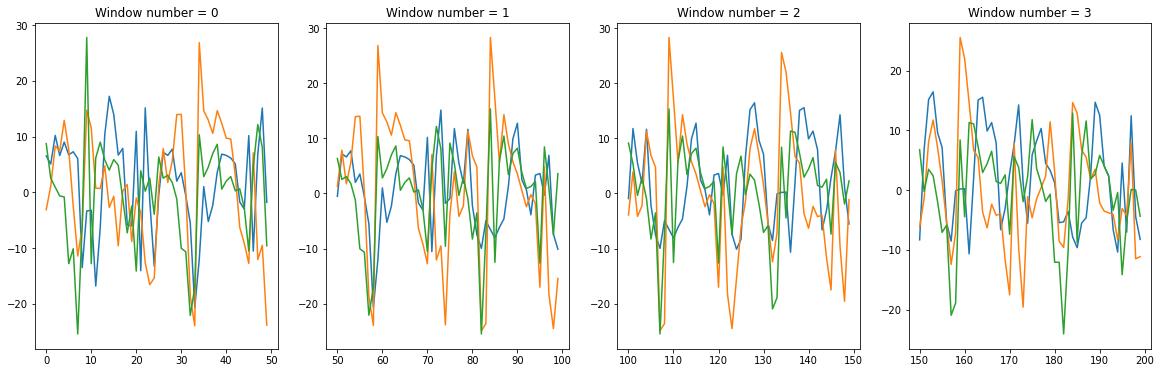

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))

for i in range(4):
    ax[i].plot(first_four_windows[i]['gyro_x'])
    ax[i].plot(first_four_windows[i]['gyro_y'])
    ax[i].plot(first_four_windows[i]['gyro_z'])
    ax[i].set_title(f"Window number = {first_four_windows[i].window_id.values[0]}")


It's also interesting to observe the dimensionality of one window. Considering just the accelerometer and gyroscope signals, with all three axes, the resulting dimensionality of one window is:

In [13]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [14]:
np.array(first_four_windows[0][columns_of_interest]).shape

(50, 6)

## From sliding windows to datapoints

Each sliding window needs to be further processed in order to represent an appropriate input datapoint. The preprocessing methods might differ depending on which type of model you choose to use. 

You can also do further processing on the signal types and axes, for example smooth the signal, apply axis fusion, eliminate noise etc. 

Here we will discuss simple examples without any preprocessing. 

### Feature extraction with tsfresh

One quick and simple method to consider for HAR is a [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). It can take a multi-dimensional datapoint as input and can output a classification. 

We can transform each window of data into one single, multidimensional datapoint by applying simple computations using the [tsfresh](https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html) package.

In [15]:
feature_list = []

for col in columns_of_interest:
    new_features = tsfresh.extract_features(timeseries_container=final_sliding_windows, column_id='window_id',
                        column_value=col, default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters())
    
    feature_list.append(new_features)
    
feature_list = pd.concat(feature_list, axis=1)

feature_list

Feature Extraction: 100%|██████████████████████| 15/15 [00:00<00:00, 436.65it/s]


,accel_x__sum_values,accel_x__median,accel_x__mean,accel_x__length,accel_x__standard_deviation,accel_x__variance,accel_x__root_mean_square,accel_x__maximum,accel_x__minimum,accel_y__sum_values,...,gyro_y__minimum,gyro_z__sum_values,gyro_z__median,gyro_z__mean,gyro_z__length,gyro_z__standard_deviation,gyro_z__variance,gyro_z__root_mean_square,gyro_z__maximum,gyro_z__minimum
0,15.572266,0.266968,0.311445,50.0,0.162455,0.026392,0.351269,0.825195,0.090332,-46.064819,...,-23.953125,-21.312500,1.335938,-0.426250,50.0,9.216061,84.935772,9.225912,27.765625,-25.421875
1,15.260742,0.257080,0.305215,50.0,0.162302,0.026342,0.345685,0.716797,-0.015381,-46.168579,...,-24.906250,4.062500,2.093750,0.081250,50.0,8.555123,73.190127,8.555509,15.312500,-25.500000
2,15.819336,0.260010,0.316387,50.0,0.164726,0.027135,0.356701,0.689453,-0.015381,-45.846314,...,-24.906250,22.718750,2.328125,0.454375,50.0,8.262333,68.266141,8.274817,15.312500,-25.500000
3,16.042969,0.285522,0.320859,50.0,0.158796,0.025216,0.358004,0.708984,0.086670,-45.779419,...,-19.578125,-21.187500,1.281250,-0.423750,50.0,8.232814,67.779225,8.243712,12.890625,-24.078125
4,16.070312,0.272095,0.321406,50.0,0.171730,0.029491,0.364408,0.771729,0.070801,-45.974975,...,-40.250000,-6.734375,1.468750,-0.134687,50.0,8.644732,74.731395,8.645781,16.765625,-24.078125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,3.352783,0.037720,0.067056,50.0,0.125699,0.015800,0.142466,0.440430,-0.150635,-50.244995,...,-48.156250,25.796875,2.539062,0.515938,50.0,6.221106,38.702163,6.242464,8.578125,-18.812500
208,2.219482,0.024536,0.044390,50.0,0.109076,0.011898,0.117762,0.440430,-0.106689,-49.942993,...,-48.156250,65.890625,2.484375,1.317813,50.0,6.184276,38.245270,6.323124,14.140625,-18.640625
209,2.070801,0.038818,0.041416,50.0,0.090022,0.008104,0.099092,0.362305,-0.195801,-50.228638,...,-54.640625,18.718750,0.398438,0.374375,50.0,6.561372,43.051601,6.572044,14.140625,-10.296875
210,5.048096,0.069824,0.100962,50.0,0.150165,0.022549,0.180949,0.443115,-0.299561,-49.792602,...,-54.640625,18.718750,0.281250,0.374375,50.0,7.179912,51.551142,7.189666,13.953125,-19.656250


Now the index represents the window ID, and each row in the DataFrame represents a multi-dimensional datapoint which we can use as input to the RFC.

You can use the window ID to refer back to the initial dataframe and get the class (activity type) for each window.

We will now process both recordings so that we have two classes for our classifier. For your own work you should only aim to perform classification on data from one sensor. 

In [16]:
window_size = 50 # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # this is 50% overlap

window_number = 0 # start a counter at 0 to keep track of the window number

all_overlapping_windows = []

for rid, group in base_df.groupby("recording_id"):
    print(f"Processing rid = {rid}")
    
    large_enough_windows = [window for window in group.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]
    
    overlapping_windows = large_enough_windows[::step_size] 
    
    # then we will append a window ID to each window
    for window in overlapping_windows:
        window.loc[:, 'window_id'] = window_number
        window_number += 1
    
    
    all_overlapping_windows.append(pd.concat(overlapping_windows).reset_index(drop=True))

Processing rid = Respeck_s1711661_Sitting bent forward_23-09-2021_19-54-06
Processing rid = Respeck_s1711661_Standing_23-09-2021_19-58-56
Processing rid = Respeck_s1711661_Walking at normal speed_23-09-2021_20-23-44
Processing rid = Respeck_s1718069_Sitting bent forward_29-09-2021_12-25-17
Processing rid = Respeck_s1718069_Standing_29-09-2021_12-26-43
Processing rid = Respeck_s1718069_Walking at normal speed_29-09-2021_12-27-51
Processing rid = Respeck_s1721256_Sitting bent forward_01-10-2021_18-46-19
Processing rid = Respeck_s1721256_Standing_01-10-2021_19-00-30
Processing rid = Respeck_s1721256_Walking at normal speed_02-10-2021_22-12-45
Processing rid = Respeck_s1724067_Sitting bent forward_03-10-2021_16-27-22
Processing rid = Respeck_s1724067_Standing_03-10-2021_16-29-48
Processing rid = Respeck_s1724067_Walking at normal speed_06-10-2021_19-54-01
Processing rid = Respeck_s1724279_Sitting bent forward_30-09-2021_12-33-17
Processing rid = Respeck_s1724279_Standing_30-09-2021_12-34-4

In [17]:
final_sliding_windows = pd.concat(all_overlapping_windows).reset_index(drop=True)

In [18]:
# now extract all features
feature_list = []

for col in columns_of_interest:
    new_features = tsfresh.extract_features(timeseries_container=final_sliding_windows, column_id='window_id',
                        column_value=col, default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters())
    
    feature_list.append(new_features)
    
feature_list = pd.concat(feature_list, axis=1)

feature_list

Feature Extraction: 100%|██████████████████████| 15/15 [00:00<00:00, 190.07it/s]


,accel_x__sum_values,accel_x__median,accel_x__mean,accel_x__length,accel_x__standard_deviation,accel_x__variance,accel_x__root_mean_square,accel_x__maximum,accel_x__minimum,accel_y__sum_values,...,gyro_y__minimum,gyro_z__sum_values,gyro_z__median,gyro_z__mean,gyro_z__length,gyro_z__standard_deviation,gyro_z__variance,gyro_z__root_mean_square,gyro_z__maximum,gyro_z__minimum
0,11.021729,0.219482,0.220435,50.0,0.005369,0.000029,0.220500,0.232178,0.210449,-45.979858,...,-1.062500,-27.281250,-0.484375,-0.545625,50.0,0.397623,0.158104,0.675137,0.140625,-1.671875
1,10.908203,0.217773,0.218164,50.0,0.005165,0.000027,0.218225,0.232666,0.207764,-46.025269,...,-0.640625,-16.968750,-0.226562,-0.339375,50.0,0.496531,0.246543,0.601431,0.781250,-1.671875
2,10.870605,0.217285,0.217412,50.0,0.006065,0.000037,0.217497,0.236084,0.206787,-46.057495,...,-0.375000,-12.265625,-0.265625,-0.245312,50.0,0.366895,0.134612,0.441350,0.781250,-1.218750
3,10.798584,0.215820,0.215972,50.0,0.005929,0.000035,0.216053,0.236084,0.205078,-46.121216,...,-1.031250,-21.546875,-0.390625,-0.430937,50.0,0.298255,0.088956,0.524083,0.265625,-1.218750
4,10.753418,0.215088,0.215068,50.0,0.005012,0.000025,0.215127,0.231201,0.205078,-46.091186,...,-1.031250,-20.781250,-0.375000,-0.415625,50.0,0.297877,0.088730,0.511346,0.203125,-1.171875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,15.464844,0.272827,0.309297,50.0,0.148841,0.022154,0.343247,0.744873,0.112793,-46.573364,...,-30.156250,-1.734375,1.078125,-0.034688,50.0,8.255099,68.146653,8.255171,15.234375,-26.265625
607,15.653565,0.280151,0.313071,50.0,0.152627,0.023295,0.348294,0.755371,0.083984,-46.160034,...,-30.156250,25.109375,0.929688,0.502188,50.0,8.535171,72.849150,8.549932,15.406250,-21.546875
608,15.821045,0.290894,0.316421,50.0,0.160029,0.025609,0.354586,0.810547,0.076172,-46.058716,...,-23.156250,-2.796875,0.859375,-0.055938,50.0,8.627438,74.432686,8.627619,15.406250,-20.343750
609,15.709717,0.289185,0.314194,50.0,0.153803,0.023655,0.349819,0.810547,0.076172,-45.876099,...,-23.156250,-43.968750,0.468750,-0.879375,50.0,8.242338,67.936143,8.289116,11.140625,-22.937500


Now we also extract the classes from each window

In [19]:
final_sliding_windows.groupby("window_id")[['activity_type']].agg(np.min)

,activity_type
window_id,
0,Sitting bent forward
1,Sitting bent forward
2,Sitting bent forward
3,Sitting bent forward
4,Sitting bent forward
...,...
606,Walking at normal speed
607,Walking at normal speed
608,Walking at normal speed


We need to assign a number to each categorical class for the Random Forest Classifer. It is mainly up to you how you categorise your classes. In this example, we will use the labels:
- 0 for Desk work
- 1 for Walking at normal speed

Bear in mind that your classification task will be multi-class, not binary. 

In [20]:
# class_labels = {
#     'Desk work': 0,
#     'Walking at normal speed': 1
# }

class_labels = {
    'Standing': 0,
    'Sitting bent forward': 1,
    'Walking at normal speed': 2
}
# 'Standing' 'Sitting bent forward' 'Walking at normal speed'

In [21]:
window_id_class_labels = final_sliding_windows.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)
window_id_class_labels

,activity_type
window_id,
0,1
1,1
2,1
3,1
4,1
...,...
606,2
607,2
608,2


### Quickly training a Random Forest Classifier

We now have all the tools to start training a Random Forest Classifier. We will use the feature_list as inputs and window_id_class_labels as outputs. We will do a basic 80/20 split of the data for demonstration purposes. 

In your project you should split the data into training and tests sets by excluding entire subjects from the training set. This is discussed later on in this notebook.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(feature_list, window_id_class_labels,
                                                    test_size=0.2, train_size=0.8)

In [23]:
print(f"Training set: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Test set: X_test = {X_test.shape}, y_test = {y_test.shape}")

Training set: X_train = (488, 54), y_train = (488, 1)
Test set: X_test = (123, 54), y_test = (123, 1)


Now we can build and train the random forest classifier

In [24]:
rfc = RandomForestClassifier(n_estimators=10)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

/tmp/ipykernel_3114/2535334845.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


In [25]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        37
           2       1.00      1.00      1.00        48

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123



This is a very easy problem so the classifier learns very quickly. Your actual problem of classifying multiple activities will be much harder.

## Leave-one-subject-out cross-validation

One of the other reason our previous classifier functions so well is that each person performs activities in a very consistent manner. If a subject's data is both in the training set and the test set, it provides the model with an unfair advantage. Moreover, the results that your model will output will be falsely high. When you test your model on a completely new, unseen subject, your accuracy will drop considerably. 

This is why when training a HAR model you will want to do a special kind of cross-validation: Leave-One-Subject-Out (LOSOXV), where we leave one (or more) subject(s) in the testing set at each iteration.

![losoxv](../Images/LOOCV.png "losoxv")

This ensures that the results we get from our classifier are consistent to what we would get in real life, if we were to test the model on a new user.

## Training a simple CNN

There are some different preprocessing techniques you can apply when the resulting "datapoint" is an input to a convolutional neural network. 

You can use two types of convolutional layers:
* 1D Conv Layers - which will work on 1D data, for example a single axis from one single sensor (accel, gyro or mag)
* 2D Conv Layers - suitable if the input data is in the form of an image, for example

We will be demonstrating how to build a simple 1D CNN using 6 channels: the 3 axes of the accelerometer and the 3 axes of the gyroscope.

### Setting up the model

### Re-generating the data in the appropriate format

We need to do a bit more work with our data to bring it into a format fit for training a CNN. 

A CNN will take multi-dimensional arrays as input. We have already specified that the input shape is (window_size, n_features), i.e. (50, 6). 

Remember that we generated sliding windows before. Now we just need to take the raw values from each window and create a training set. 

In [26]:
columns_of_interest

['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [27]:
X = []
y = []

for window_id, group in final_sliding_windows.groupby('window_id'):
    print(f"window_id = {window_id}")
    
    shape = group[columns_of_interest].values.shape
    print(f"shape = {shape}")
    
    X.append(group[columns_of_interest].values)
    y.append(class_labels[group["activity_type"].values[0]])

window_id = 0
shape = (50, 6)
window_id = 1
shape = (50, 6)
window_id = 2
shape = (50, 6)
window_id = 3
shape = (50, 6)
window_id = 4
shape = (50, 6)
window_id = 5
shape = (50, 6)
window_id = 6
shape = (50, 6)
window_id = 7
shape = (50, 6)
window_id = 8
shape = (50, 6)
window_id = 9
shape = (50, 6)
window_id = 10
shape = (50, 6)
window_id = 11
shape = (50, 6)
window_id = 12
shape = (50, 6)
window_id = 13
shape = (50, 6)
window_id = 14
shape = (50, 6)
window_id = 15
shape = (50, 6)
window_id = 16
shape = (50, 6)
window_id = 17
shape = (50, 6)
window_id = 18
shape = (50, 6)
window_id = 19
shape = (50, 6)
window_id = 20
shape = (50, 6)
window_id = 21
shape = (50, 6)
window_id = 22
shape = (50, 6)
window_id = 23
shape = (50, 6)
window_id = 24
shape = (50, 6)
window_id = 25
shape = (50, 6)
window_id = 26
shape = (50, 6)
window_id = 27
shape = (50, 6)
window_id = 28
shape = (50, 6)
window_id = 29
shape = (50, 6)
window_id = 30
shape = (50, 6)
window_id = 31
shape = (50, 6)
window_id = 32
sha

window_id = 397
shape = (50, 6)
window_id = 398
shape = (50, 6)
window_id = 399
shape = (50, 6)
window_id = 400
shape = (50, 6)
window_id = 401
shape = (50, 6)
window_id = 402
shape = (50, 6)
window_id = 403
shape = (50, 6)
window_id = 404
shape = (50, 6)
window_id = 405
shape = (50, 6)
window_id = 406
shape = (50, 6)
window_id = 407
shape = (50, 6)
window_id = 408
shape = (50, 6)
window_id = 409
shape = (50, 6)
window_id = 410
shape = (50, 6)
window_id = 411
shape = (50, 6)
window_id = 412
shape = (50, 6)
window_id = 413
shape = (50, 6)
window_id = 414
shape = (50, 6)
window_id = 415
shape = (50, 6)
window_id = 416
shape = (50, 6)
window_id = 417
shape = (50, 6)
window_id = 418
shape = (50, 6)
window_id = 419
shape = (50, 6)
window_id = 420
shape = (50, 6)
window_id = 421
shape = (50, 6)
window_id = 422
shape = (50, 6)
window_id = 423
shape = (50, 6)
window_id = 424
shape = (50, 6)
window_id = 425
shape = (50, 6)
window_id = 426
shape = (50, 6)
window_id = 427
shape = (50, 6)
window_i

In [28]:
X = np.asarray(X)
y = np.asarray(y)

print(f"X shape = {X.shape}")
print(f"y shape = {y.shape}")

X shape = (611, 50, 6)
y shape = (611,)


We can do a similar test/train split for demonstration purposes. Remember that you will have to split your data by subjects, not radomly.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, train_size=0.8)

y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
y_test = np.asarray(pd.get_dummies(y_test), dtype=np.float32)

In [30]:
print(f"X_train shape = {X_train.shape}")
print(f"y_train shape = {y_train.shape}")

print(f"X_test shape = {X_test.shape}")
print(f"y_test shape = {y_test.shape}")

X_train shape = (488, 50, 6)
y_train shape = (488, 3)
X_test shape = (123, 50, 6)
y_test shape = (123, 3)


Now we are ready to start the training process

## Defining different tensorflow models 

In [31]:
filters = 64
kernel_size = 3
n_features = 6
activation='relu'
n_classes = 3

In [32]:
#Model 1 CNN model (default):

model = Sequential()

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear', 
                 input_shape=(window_size, n_features)))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

2021-10-19 03:46:51.858538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 03:46:52.270906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 03:46:52.272150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 03:46:52.275229: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 48, 64)            1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 64)            256       
_________________________________________________________________
activation (Activation)      (None, 48, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 64)            12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 64)            256       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 44, 64)            1

In [33]:
model.compile(
    optimizer=optimizers.SGD(lr=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

/home/jerry/anaconda3/envs/pdiot/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [34]:
model.fit(X_train, y_train,
        batch_size=2, epochs=100)

2021-10-19 03:46:57.167954: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-10-19 03:47:01.952516: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


244/244 [==============================] - 18s 4ms/step - loss: 0.6283 - accuracy: 0.4672
Epoch 2/100
244/244 [==============================] - 1s 4ms/step - loss: 0.5332 - accuracy: 0.5656
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 0.5174 - accuracy: 0.5656
Epoch 4/100
244/244 [==============================] - 1s 3ms/step - loss: 0.4901 - accuracy: 0.6230
Epoch 5/100
244/244 [==============================] - 1s 4ms/step - loss: 0.4761 - accuracy: 0.6127
Epoch 6/100
244/244 [==============================] - 1s 4ms/step - loss: 0.4612 - accuracy: 0.6209
Epoch 7/100
244/244 [==============================] - 1s 4ms/step - loss: 0.4365 - accuracy: 0.6660
Epoch 8/100
244/244 [==============================] - 1s 4ms/step - loss: 0.4248 - accuracy: 0.6885
Epoch 9/100
244/244 [==============================] - 1s 3ms/step - loss: 0.4060 - accuracy: 0.7295
Epoch 10/100
244/244 [==============================] - 1s 4ms/step - loss: 0.4020 - accuracy: 0.7070


244/244 [==============================] - 1s 4ms/step - loss: 0.1179 - accuracy: 0.9508
Epoch 82/100
244/244 [==============================] - 1s 4ms/step - loss: 0.1113 - accuracy: 0.9549
Epoch 83/100
244/244 [==============================] - 1s 4ms/step - loss: 0.1038 - accuracy: 0.9570
Epoch 84/100
244/244 [==============================] - 1s 5ms/step - loss: 0.1162 - accuracy: 0.9426
Epoch 85/100
244/244 [==============================] - 1s 6ms/step - loss: 0.1067 - accuracy: 0.9611
Epoch 86/100
244/244 [==============================] - 1s 3ms/step - loss: 0.1097 - accuracy: 0.9508
Epoch 87/100
244/244 [==============================] - 1s 4ms/step - loss: 0.1082 - accuracy: 0.9549
Epoch 88/100
244/244 [==============================] - 1s 4ms/step - loss: 0.1073 - accuracy: 0.9549
Epoch 89/100
244/244 [==============================] - 1s 5ms/step - loss: 0.1041 - accuracy: 0.9570
Epoch 90/100
244/244 [==============================] - 2s 7ms/step - loss: 0.1059 - accuracy: 

In [36]:
# Save the weights
model.save_weights('./checkpoints/cnn_checkpoint.h5')

# Transfer the tensorflow model to tflite model:

In [38]:
# Transfer the tensorflow model to tflite model:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
print(tf.__version__)

2.6.0


In [41]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [42]:
KERAS_MODEL_NAME = "tf_model.h5"
model.save(KERAS_MODEL_NAME)
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

File size: 1.218 Megabytes
4/4 - 0s - loss: 0.5325 - accuracy: 0.7642

Test accuracy: 0.7642276287078857


In [43]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

2021-10-19 04:01:32.347546: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpgpaypj1g/assets


2021-10-19 04:01:33.212402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 04:01:33.213608: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-10-19 04:01:33.213854: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-10-19 04:01:33.214715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 04:01:33.215638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 04:01:33.216499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

File size: 1209.922 Kilobytes


2021-10-19 04:01:33.463268: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2021-10-19 04:01:33.463343: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2021-10-19 04:01:33.597368: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


In [44]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 50  6]
Input Type: <class 'numpy.float32'>
Output Shape: [1 3]
Output Type: <class 'numpy.float32'>


In [46]:
len(y_test)

123

In [47]:
interpreter.resize_tensor_input(input_details[0]['index'], (len(y_test), 50, 6))
interpreter.resize_tensor_input(output_details[0]['index'], (len(y_test), 3))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [123  50   6]
Input Type: <class 'numpy.float32'>
Output Shape: [123   3]
Output Type: <class 'numpy.float32'>


In [49]:
X_test_numpy = np.array(X_test, dtype=np.float32)

In [50]:
interpreter.set_tensor(input_details[0]['index'], X_test_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (123, 3)


In [64]:
y_test[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [63]:
acc = accuracy_score(prediction_classes, np.argmax(y_test, axis=1))
print('Test accuracy TFLITE model :', acc)

Test accuracy TFLITE model : 0.7642276422764228


In [61]:
np.argmax(y_test, axis=1),np.argmax(y_test, axis=1).shape

(array([0, 0, 2, 2, 2, 2, 1, 2, 1, 1, 0, 2, 0, 0, 1, 1, 0, 1, 0, 2, 0, 2,
        1, 0, 2, 1, 0, 1, 2, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 2, 2, 2,
        1, 0, 1, 1, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 0, 1, 1, 0, 2, 2, 0,
        2, 1, 1, 1, 0, 2, 1, 0, 1, 2, 1, 0, 2, 1, 0, 2, 0, 0, 1, 2, 0, 0,
        2, 1, 0, 0, 1, 1, 0, 2, 1, 1, 2, 1, 1, 0, 2, 2, 0, 0, 1, 1, 2, 0,
        1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 1, 2, 2]),
 (123,))

In [35]:
#Model 2 LSTM model (default):

N_CLASSES = 3
N_HIDDEN_UNITS = 512

# define model
model = Sequential()

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear', 
                 input_shape=(window_size, n_features)))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(LSTM(N_HIDDEN_UNITS, activation='relu', kernel_initializer='he_normal', input_shape=(None, 64))) #, input_shape=(n_steps,1)))
model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(N_CLASSES, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 48, 64)            1216      
_________________________________________________________________
batch_normalization_3 (Batch (None, 48, 64)            256       
_________________________________________________________________
activation_3 (Activation)    (None, 48, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 46, 64)            12352     
_________________________________________________________________
batch_normalization_4 (Batch (None, 46, 64)            256       
_________________________________________________________________
activation_4 (Activation)    (None, 46, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 44, 64)           

In [56]:
##### CNN_LSTM
from tensorflow.keras.layers import ConvLSTM1D, TimeDistributed

def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''
 
    # We will use a Sequential model for model construction
    model = Sequential()
 
    # Define the Model Architecture.
    ########################################################################################################################
#     model.add(tf.keras.layers.)
    
    model.add(ConvLSTM1D(filters = 4, kernel_size = (3,3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape=(window_size, n_features, 1)))
    
#     model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM1D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
#     model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM1D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
#     model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM1D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
#     model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [54]:

# # Construct the required convlstm model.
# convlstm_model = create_convlstm_model()
 
# # Display the success message. 
# print("Model Created Successfully!")

In [34]:
# # first add an axis to your data
# X = tf.expand_dims(X_train, axis=-1)   # now X has a shape of (n_samples, n_timesteps, n_feats, 1)
# print(X_train.shape)
# print(X.shape)
# y_pred_oheaa = model.predict(X)
# y_pred_oheaa

In [59]:
model.compile(
    optimizer=optimizers.SGD(lr=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

/home/jerry/anaconda3/envs/pdiot/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [63]:
model.fit(X_train, y_train,
        batch_size=2, epochs=200)

Epoch 1/200
244/244 [==============================] - 5s 21ms/step - loss: 0.2137 - accuracy: 0.8566
Epoch 2/200
244/244 [==============================] - 5s 21ms/step - loss: 0.1819 - accuracy: 0.8648
Epoch 3/200
244/244 [==============================] - 5s 21ms/step - loss: 0.1916 - accuracy: 0.8525
Epoch 4/200
244/244 [==============================] - 5s 21ms/step - loss: 0.2272 - accuracy: 0.8525
Epoch 5/200
244/244 [==============================] - 5s 21ms/step - loss: 0.2318 - accuracy: 0.8463
Epoch 6/200
244/244 [==============================] - 5s 22ms/step - loss: 0.2419 - accuracy: 0.8545
Epoch 7/200
244/244 [==============================] - 5s 22ms/step - loss: 0.2806 - accuracy: 0.7848
Epoch 8/200
244/244 [==============================] - 5s 22ms/step - loss: 0.2475 - accuracy: 0.8053
Epoch 9/200
244/244 [==============================] - 5s 21ms/step - loss: 0.2366 - accuracy: 0.8484
Epoch 10/200
244/244 [==============================] - 5s 22ms/step - loss: 0.229

244/244 [==============================] - 5s 21ms/step - loss: 0.0537 - accuracy: 0.9672
Epoch 159/200
244/244 [==============================] - 5s 21ms/step - loss: 0.0402 - accuracy: 0.9754
Epoch 160/200
244/244 [==============================] - 5s 21ms/step - loss: 0.0336 - accuracy: 0.9836
Epoch 161/200
244/244 [==============================] - 5s 22ms/step - loss: 0.0351 - accuracy: 0.9754
Epoch 162/200
244/244 [==============================] - 5s 21ms/step - loss: 0.0272 - accuracy: 0.9857
Epoch 163/200
244/244 [==============================] - 5s 21ms/step - loss: 0.0477 - accuracy: 0.9713
Epoch 164/200
244/244 [==============================] - 5s 21ms/step - loss: 0.0208 - accuracy: 0.9918
Epoch 165/200
244/244 [==============================] - 5s 21ms/step - loss: 0.0302 - accuracy: 0.9816
Epoch 166/200
244/244 [==============================] - 5s 21ms/step - loss: 0.0368 - accuracy: 0.9775
Epoch 167/200
244/244 [==============================] - 5s 21ms/step - loss: 

We can now view the accuracy of our model on the test dataset.

In [64]:
# stats
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

In [65]:
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_true_labels, y_pred_labels))

********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.83      0.69      0.75        42
           1       0.73      1.00      0.84        37
           2       1.00      0.84      0.91        44

    accuracy                           0.84       123
   macro avg       0.85      0.84      0.84       123
weighted avg       0.86      0.84      0.84       123



In [66]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

# # Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

# Evaluate the model
# loss, acc = model.evaluate(test_images, test_labels, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))


In [49]:
# model.save_weights('./checkpoints/my_checkpoint.ckpt')

In [68]:
model.save_weights('./checkpoints/my_checkpoint.h5')

In [47]:
# stats
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_true_labels, y_pred_labels))

********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.87      0.69      0.77        48
           1       0.72      1.00      0.84        38
           2       1.00      0.86      0.93        37

    accuracy                           0.84       123
   macro avg       0.86      0.85      0.84       123
weighted avg       0.86      0.84      0.84       123



In [52]:
# Now, look at the resulting checkpoints and choose the latest one:

os.listdir('./checkpoints/')

['my_checkpoint.ckpt.index',
 'my_checkpoint.h5',
 'checkpoint',
 'my_checkpoint.ckpt.data-00000-of-00001',
 'my_checkpoint.data-00000-of-00001',
 'my_checkpoint.index']

In [54]:
latest = tf.train.latest_checkpoint('./checkpoints/')
latest

'./checkpoints/my_checkpoint.ckpt'

In [45]:
model.load_weights('./checkpoints/my_checkpoint')

In [46]:
model.compile(
    optimizer=optimizers.SGD(lr=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

/home/jerry/anaconda3/envs/pdiot/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [48]:
# Another way to Evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

4/4 - 0s - loss: 1.0892 - accuracy: 0.8374
Restored model, accuracy: 83.74%


## Conclusion

You are now ready to start developing your own models for HAR. There are numerous tutorials online which you can follow to build models like LSTMs, CNNs, RFCs and many others. 

You have a wide choice of ways to solve this classification model. Here are a few things to think about:

* What type of preprocessing do you want to apply to your data? Examples include:
    * smoothing the sensor axes
    * performing axis fusion
    * extracting scalograms from the signal
    * manually extracting features from the signal
    * choosing to leave out certain axes

* What type of model do you want to train?
    * simple ML model
    * deep learning model
    
* Do you want a hierarchical model or a flat model?
    * hierarchical models means you don't have to train the same type of model for each activity
    * a flat model might be faster to train and apply in real time